# Imports

In [14]:
import numpy as np
import pandas as pd

print(np.__version__)

import pickle

import os

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# 2D ploting imports
import plotly

# 3-D plot using surface graph
import plotly.graph_objs as go
import numpy as np
import plotly.io as pio
from scipy.interpolate import griddata


from tqdm import tqdm

# ignore warnings
import warnings
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from tqdm import tqdm

# ignore warnings
import warnings

warnings.filterwarnings("ignore")

1.23.5


# Helper functions

In [1]:
# Retreive value of given index
def get_value(y, index):
    x = y[index]
    return x


def add_uniform_noise(probas, noise_level=0.1):
    """
    Adds random uniform noise to a list of probabilities.

    Parameters:
    probas (list of float): List of probabilities to add noise to.
    noise_level (float): Maximum amount of noise to add. Noise will be in the range [-noise_level, noise_level].

    Returns:
    list of float: Probabilities with added noise.
    """
    noise = np.random.uniform(-noise_level, noise_level, len(probas))
    probas += noise
    probas = (probas - min(probas)) / (max(probas) - min(probas))

    return probas


# Harmonic mean
def harmonic_mean(a, b):
    return 2 * a * b / (a + b) if (a + b) != 0 else 0.0


def weighted_bce_loss(y, y_hat):
    # Calculate the lambda value
    N_bad = np.sum(y)
    N = len(y)
    N_good = N - N_bad
    lam = N_good / N

    # Ensure y_hat values are in (0, 1)
    epsilon = 1e-8
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)

    # Calculate the weighted BCE loss
    wBCE_loss = (-2 / N) * np.sum(
        lam * y * np.log(y_hat) + (1 - lam) * (1 - y) * np.log(1 - y_hat)
    )

    return wBCE_loss


# Scoring function
def scoring(*, y_true, y_pred, y_pred_proba=None, metric="harmonic_tnr_recall"):
    """
    input: true_labels, predicted_labels, predicted_probabilities, metric
    output: score
    metric: 'harmonic_tnr_recall', 'harmonic_tnr_precision', 'f1', 'precision', 'recall', 'tnr', 'weighted_binary_cross_entropy'
    """

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Define available metrics
    metrics = {
        "harmonic_tnr_recall": lambda tn, fp, fn, tp: harmonic_mean(
            tn / (tn + fp) if (tn + fp) != 0 else 0,
            tp / (tp + fn) if (tp + fn) != 0 else 0,
        ),
        "harmonic_tnr_precision": lambda tn, fp, fn, tp: harmonic_mean(
            tn / (tn + fp) if (tn + fp) != 0 else 0,
            tp / (tp + fp) if (tp + fp) != 0 else 0,
        ),
        "f1": lambda tn, fp, fn, tp: f1_score(y_true, y_pred),
        "precision": lambda tn, fp, fn, tp: precision_score(y_true, y_pred),
        "recall": lambda tn, fp, fn, tp: recall_score(y_true, y_pred),
        "tnr": lambda tn, fp, fn, tp: tn / (tn + fp) if (tn + fp) != 0 else 0.0,
        "weighted_binary_cross_entropy": lambda y_true, y_pred_proba: weighted_bce_loss(
            y_true, y_pred_proba
        ),
    }

    # Calculate the chosen metric
    if metric in metrics:
        if metric == "weighted_binary_cross_entropy":
            if y_pred_proba is None:
                raise ValueError(
                    "y_pred_proba must be provided when using 'weighted_binary_cross_entropy' as the metric"
                )
            score = metrics[metric](y_true, y_pred_proba)
        else:
            score = metrics[metric](tn, fp, fn, tp)
        return score
    else:
        raise ValueError(
            f"Metric '{metric}' not recognized. Available metrics: {list(metrics.keys())}"
        )


# Find mean gap between 1's in the data
def find_mean_gap(y):
    # Find the indices of 1's in the data
    ones_indices = np.where(y == 1)[0]
    # Calculate the differences between consecutive 1's
    gaps = np.diff(ones_indices)
    # Calculate the mean gap
    mean_gap = int(np.mean(gaps))
    return mean_gap


def transform_data(y, trained_probas, predictions, mean_gap_ref):
    y_transformed, probas_list, predictions_list = [], [], []
    y_transform = y.copy()  # Copy of the original data
    probas = trained_probas.copy()

    i, start = (
        0,
        0,
    )  # i : index of the current element, start : index of the first element in the current chunk

    while i < len(y_transform):
        mean_gap = np.random.randint(256, mean_gap_ref + 950)
        if (
            len(y_transform[i:]) < mean_gap
        ):  # if the remaining data is less than the mean gap break
            break

        elif (
            y_transform[start] == 1
        ):  # if the first element in the chunk is 1, move to the next element
            start += 1
            i += 1
            continue

        elif y_transform[i] == 1:
            # if the current element is 1, fill the chunk with 1's by the mean gap
            probas_chunk, predictions_chunk, y_chunk = (
                probas[start : i + mean_gap],
                predictions[start : i + mean_gap],
                y[start : i + mean_gap],
            )

            ones_places = np.where(y_chunk == 1)[0]

            for one_place in ones_places:

                y_chunk = np.zeros(len(y_chunk))
                y_chunk[one_place] = 1
                y_transform_chunk = y_chunk.copy()

                y_transform_chunk[np.where(y_chunk == 1)[0][0] + 1 :] = 1

                # append the chunk to the transformed data
                y_transformed.append([y_chunk, y_transform_chunk])
                # append the chunk of probabilities to the list
                probas_list.append(probas_chunk)
                # append the chunk of predictions to the list
                predictions_list.append(predictions_chunk)

            # move the index to the next element after the chunk
            # set the start index to the current index
            i += mean_gap
            start = i
            continue

        else:
            i += 1

    return y_transformed, probas_list, predictions_list


# Check transformation validity
def check_transformation(data_transformed):
    for chunk_pair in data_transformed:
        if len(np.where(chunk_pair[0] == 1)[0]) > 1:
            raise ValueError("more than one 1 found in the original data")
        if len(chunk_pair[0]) != len(
            chunk_pair[1]
        ):  # checking if the length of the original and transformed data are equal
            raise ValueError("lenght mismatch found")

        for i in range(
            len(chunk_pair[0])
        ):  # looping over each intity in each chunk pair
            sum_chunk = sum(chunk_pair[0][i + 1 :])

            if chunk_pair[0][i] == 0 and chunk_pair[1][i] == 0:
                continue

            # if the su of the remaining chunk is equal to the sum from index to the end of the list, then the transformation is valid
            # example --> trans = [0,0,0,0,1,1,1,1], len:8, index:4, sum(trans)[index:] == 4 == len(trans) - 4
            elif (len(chunk_pair[0]) - i == sum(chunk_pair[1][i:])) and sum_chunk == 0:
                return True
            else:
                print(
                    f"false transformation found at index {i}, {chunk_pair[0]} and {chunk_pair[1]}"
                )
                return False


# Plot the data
def plot(
    algorithm,
    metric=None,
    *,
    samples=15000,
    scores=None,
    saved_runs=None,
    save_fig=False,
    transparent=False,
    **kwargs,
):

    plt.figure(figsize=(18, 9))

    saved_runs_means = [np.mean(saved_run) for saved_run in saved_runs]
    scores_means = [np.mean(score) for score in scores]
    # Find the vertical line where saved runs become negative
    negative_indices = [
        i for i, saved_run in enumerate(saved_runs_means) if saved_run < 0
    ]

    if negative_indices:
        negative_index = negative_indices[
            -1
        ]  # Find the last index where saved runs are negative
        # Perform linear interpolation
        x1 = scores_means[negative_index]
        y1 = saved_runs_means[negative_index]
        x2 = scores_means[negative_index + 1]
        y2 = saved_runs_means[negative_index + 1]

        x_zero_cross = x1 + (0 - y1) / (y2 - y1) * (x2 - x1)

        plt.axvline(
            x=x_zero_cross,
            color="#EC6602",
            linestyle="--",
            linewidth=1.5,
            label="_nolegend_",
        )
        plt.axhline(
            y=0,
            color="#EC6602",
            linestyle="--",
            linewidth=1.5,
            label="_nolegend_",
        )
        x_zero_cross = f"{x_zero_cross:.2f}%"
        # plt.axhline(y=0, color="#EC6602", linestyle="--", linewidth=1.5)

    else:
        x_zero_cross = None
    # Plot with labels for the legend
    plt.boxplot(saved_runs, positions=scores_means, widths=2)

    plt.plot(
        scores_means,
        saved_runs_means,
        marker="o",
        linestyle="--",
        color="#009999",
        label="_nolegend_",
        **kwargs,
    )

    plt.legend(
        [f"Samples: {samples}\nThreshold: {x_zero_cross}"],
        loc="upper right",
        fontsize=10,
        frameon=True,
        shadow=False,
        title="Info",
        title_fontsize="20",
    )
    # plt.title('Saved Runs Vs Model Scores using Hit Or Miss Algorithm', fontsize=20)
    if metric == "Weighted Binary Crossentropy Loss":
        plt.xlabel(f"Loss Values ({metric})", fontsize=25)
    else:
        plt.xlabel(f"Score Values ({metric})", fontsize=25)
    plt.ylabel("Saved Runs", fontsize=25)

    # remoce borders
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    # min = int(np.min(saved_runs_means))
    # max = int(np.max(saved_runs_means))

    plt.xticks(ticks=range(0, 101, 10), labels=range(0, 101, 10), fontsize=20)
    plt.yticks(fontsize=20)
    ax = plt.gca()

    plt.grid(True)

    # ax.yaxis.set_major_locator(MaxNLocator(nbins=20))
    # ax.xaxis.set_major_locator(MaxNLocator(nbins=15))

    plt.xlim(-1, np.max(scores_means) + 10)
    plt.ylim(np.min(saved_runs_means) - 10, np.max(saved_runs_means) + 10)

    plt.grid(True)
    if save_fig:
        if transparent:
            transparency = "transparent"
        else:
            transparency = "non-transparent"

        directory = "Graphs/"

        if not os.path.exists(directory):
            os.makedirs(directory)

        plt.savefig(
            os.path.join(directory, f"{algorithm}_{transparency}_{metric}.png"),
            transparent=transparent,
            dpi=350,
        )

    plt.show


# 3D ploting
# 3D plot
def plot_3d(
    x,
    y,
    z,
    title="3D Plot",
    x_label="X",
    y_label="Y",
    z_label="Z",
    save_fig=False,
    transparent=False,
    width=800,
    height=800,
    algorithm="algorithm",
    contour=False,
):
    """This function plots the 3D graph of the data using plotly
    in contour plot the z axis is represented by colors"""

    # Convert input lists to numpy arrays and flatten them
    X = np.array(x)
    Y = np.array(y)
    Z = np.array(z)

    if contour:

        # Create grid values first
        grid_x, grid_y = np.mgrid[min(X) : max(X) : 80j, min(Y) : max(Y) : 80j]
        # grid_x, grid_y = np.meshgrid(np.linspace(np.min(X), np.max(X), 50), np.linspace(np.min(Y), np.max(Y), 50))
        # Interpolate using cubic interpolation

        grid_z = griddata((X, Y), Z, (grid_x, grid_y), method="nearest")

        # contour plot using matplotlib not plotly

        plt.contourf(grid_x, grid_y, grid_z, levels=29, cmap="viridis")
        plt.colorbar()
        # hide the title of the graph
        # plt.title('Contour Plot with Cubic Interpolation')

        # naming axis
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.show()
        # save the contour plot
        plt.savefig(f"{algorithm}_contourV1.png")

        if save_fig:
            if transparent:
                transparency = "transparent"

                # save the figure in png extension with name of the algorithm and transparency
                plt.savefig(
                    f"{algorithm}_transContourV1_{transparency}.png", transparent=True
                )

            else:
                transparency = "non-transparent"

                # save the figure in png extension with name of the algorithm and transparency
                plt.savefig(f"{algorithm}nontransContourV1.png")
        return

    # Create grid values first
    grid_x, grid_y = np.meshgrid(
        np.linspace(np.min(X), np.max(X), 50), np.linspace(np.min(Y), np.max(Y), 50)
    )

    # Interpolate the z values on the grid using 'nearest' method
    grid_z = griddata((X, Y), Z, (grid_x, grid_y), method="linear")

    # Create the 3D surface plot
    surface = go.Surface(x=grid_x, y=grid_y, z=grid_z, colorscale="Viridis")

    layout = go.Layout(
        title=title,
        scene=dict(xaxis_title=x_label, yaxis_title=y_label, zaxis_title=z_label),
        width=width,
        height=height,
    )
    fig = go.Figure(data=[surface], layout=layout)
    fig.show()

    if save_fig:
        if transparent:
            transparency = "transparent"
            layout_trans = go.Layout(
                title=title,
                scene=dict(
                    xaxis_title=x_label, yaxis_title=y_label, zaxis_title=z_label
                ),
                paper_bgcolor="rgba(0,0,0,0)",  # Transparent background for the plot
                plot_bgcolor="rgba(0,0,0,0)",  # Transparent background for the plot
                width=width,
                height=height,
            )
            fig = go.Figure(data=[surface], layout=layout_trans)
            # save the figure in png extension with name of the algorithm and transparency
            pio.write_image(fig, f"{algorithm}_trans3d.png")

        else:
            transparency = "non-transparent"

            # save the figure in png extension with name of the algorithm and transparency
            pio.write_image(fig, f"{algorithm}nontrans_3d.png")

# Algorithms

In [2]:
# Binary search
def find_bad_cl(y):
    num_of_runs = 0
    low, high = 0, len(y) - 1

    state_of_first = get_value(y, 0)
    state_of_last = get_value(y, len(y) - 1)

    if state_of_first == 0 and state_of_last == 0:
        return -1, num_of_runs

    while low < high:
        mid = (low + high) // 2

        state_of_current = get_value(y, mid)
        num_of_runs += 1

        if state_of_current == 0:
            low = mid + 1
        elif state_of_current == 1:
            high = mid

    result = high
    binary_runs = []
    binary_runs.append(num_of_runs)
    return num_of_runs, result


# Helper function for equilibrium
def diffs(probas, low):
    diffs = [
        abs(sum1 - sum2)
        for sum1, sum2 in [
            (sum(probas[: i + 1]), sum(probas[i:])) for i in range(1, len(probas))
        ]
    ]
    index = np.argmin(diffs)
    index += low
    return index, diffs


# Equilibruim algorithm
def equilibrium(*, data_transformed, probas):
    num_of_runs = 0

    data_transformed_len = len(data_transformed[1])
    low, high = 0, data_transformed_len - 1

    state_of_first = get_value(data_transformed[1], 0)
    state_of_last = get_value(data_transformed[1], data_transformed_len - 1)

    if state_of_first == 0 and state_of_last == 0:
        return -1, num_of_runs

    heuristic_runs = []

    previous_mid = -1
    while len(probas[low:high]) >= 1:
        mid, _ = diffs(probas[low : high + 1], low)
        state_of_current = get_value(data_transformed[1], mid)
        num_of_runs += 1

        if state_of_current == 0 and previous_mid != mid:
            low = mid + 1

        elif state_of_current == 1 and previous_mid != mid:
            high = mid

        else:
            return num_of_runs, high

        previous_mid = mid

    heuristic_runs.append(num_of_runs)
    return num_of_runs, high


# Hit or Miss algorithm
def hit_or_miss(data_transformed, probas_and_idxs):
    heuristic_runs = 0
    dynamic = [-1 for _ in range(len(data_transformed[1]))]

    highest_probas = sorted(probas_and_idxs, key=lambda t: t[0], reverse=True)

    for _, idx in highest_probas:
        if dynamic[idx] != -1:
            continue

        test_outcome = get_value(data_transformed[1], idx)
        heuristic_runs += 1

        dynamic[idx] = test_outcome

        if test_outcome == 1:
            prev_outcome = get_value(data_transformed[1], idx - 1)
            heuristic_runs += 1
            dynamic[idx - 1] = prev_outcome

            if prev_outcome == 0:
                return heuristic_runs, idx

        for i, val in enumerate(dynamic):
            if val == 1 and dynamic[i - 1] == 0:
                return heuristic_runs, i

    return heuristic_runs, len(data_transformed[1]) - 1


# Helper function to caluclate the score for Balanced Intelligent Reduction
def get_score(i, low, mid, high, alpha, beta, proba):
    proba_factor = alpha * proba
    position_factor = 1 - beta * (np.abs(i - mid) / (high - low))
    score = proba_factor + position_factor
    return score


# Balanced Intelligent Reduction algorithm
def balanced_intelligent_reduction(transformed, probas, weight, harmonic):
    alpha = weight * harmonic
    beta = 1 - alpha

    dynamic_list = [-1 for _ in range(len(transformed[1]))]
    heuristic_runs = 0

    high = len(transformed[1]) - 1
    low = 0

    previous_idx = -1

    while len(dynamic_list[low:high]) >= 1:
        mid = (high + low) // 2

        initial_scores = [
            (get_score(i, low, mid, high, alpha, beta, probas[i]), i)
            for i in range(low, high + 1)
        ]
        scores = sorted(initial_scores, key=lambda x: x[0], reverse=True)
        idx = scores[0][1]

        test_outcome = get_value(transformed[1], idx)
        heuristic_runs += 1

        dynamic_list[idx] = test_outcome

        for i, num in enumerate(dynamic_list):
            if num == 1 and dynamic_list[i - 1] == 0:
                return heuristic_runs, i

        if test_outcome == 1:
            high = idx
            if previous_idx == idx:
                return heuristic_runs, idx
            previous_idx = idx

        elif test_outcome == 0:
            low = idx + 1

    return heuristic_runs, idx


# Hybrid search algorithm
def hybrid_search(commits, probabilities, alpha):
    num_of_runs = 0
    len_commits = len(commits)
    low, high = 0, len_commits - 1

    state_of_first = get_value(commits, 0)
    state_of_last = get_value(commits, len_commits - 1)

    if state_of_first == 0 and state_of_last == 0:
        return -1, num_of_runs

    while low < high:
        binary_mid = (low + high) // 2

        # alpha is the weight of the probabilities and adjustable parameter
        prob_mid, diffs_ = diffs(probabilities[low : high + 1], low)
        new_mid = int(((alpha * prob_mid) + ((1 - alpha) * binary_mid)))

        num_of_runs += 1
        if commits[new_mid] == 1:
            high = new_mid

        elif commits[new_mid] == 0:
            low = new_mid + 1

    return num_of_runs, high

# Run

In [22]:
def Run(
    *,
    X,
    y,
    mean_gap_ref,
    model,
    metric,
    comparison=False,
    algorithm="equilibrium",
    noise_level,
    **kwargs,
):
    """
    input: model, metric, stats, comparison, algorithm, WBCE_weights, BIR_weight
    output: saved_runs, average_score
    WBCE_weights: Weights for the weighted binary crossentropy
    BIR_weight: Weight for the Balanced Intelligent Reduction

    """

    algorithms = [
        "equilibrium",
        "hit_or_miss",
        "balanced_intelligent_reduction",
        "hybrid_search",
    ]

    scores = []

    trained_probas = model.predict_proba(X)[:, 1]
    predictions = model.predict(X)

    y_transformed, probas, predictions = transform_data(
        y, trained_probas, predictions, mean_gap_ref
    )
    transformation_valid = check_transformation(y_transformed)

    binary_runs_list = []
    heuristic_runs_list = []
    probas = [add_uniform_noise(proba, noise_level=noise_level) for proba in probas]
    if not transformation_valid:
        raise ValueError("Transformation is not valid")

    # add noise to the probabilities

    for transformed, (proba, prediction) in zip(
        y_transformed, zip(probas, predictions)
    ):
        # transformed[0] for original data
        # transformed[1] for transformed data

        binary_runs, binary_result = find_bad_cl(transformed[1])
        score = scoring(
            y_true=transformed[0], y_pred=prediction, y_pred_proba=proba, metric=metric
        )
        scores.append(score)

        if algorithm in algorithms:
            if algorithm == "equilibrium":
                heuristic_runs, heuristic_result = equilibrium(
                    data_transformed=transformed, probas=proba
                )

            elif algorithm == "hit_or_miss":
                probas_and_idxs = [(proba[i], i) for i in range(len(proba))]
                heuristic_runs, heuristic_result = hit_or_miss(
                    data_transformed=transformed, probas_and_idxs=probas_and_idxs
                )

            elif algorithm == "balanced_intelligent_reduction":
                heuristic_runs, heuristic_result = balanced_intelligent_reduction(
                    transformed=transformed,
                    probas=proba,
                    weight=kwargs.get("BIR_weight", 0.5),
                    harmonic=score,
                )
            elif algorithm == "hybrid_search":
                alpha = kwargs.get("alpha", 0.5)
                heuristic_runs, heuristic_result = hybrid_search(
                    commits=transformed[1], probabilities=proba, alpha=alpha
                )
        else:
            raise ValueError(
                f"Algorithm not found. Choose one of the following: {algorithms}"
            )

        try:
            if binary_result == heuristic_result:
                pass
            else:
                raise ValueError("Results do not match")
        except:
            print("Error")
            print(
                f"binary_result: {binary_result}, heuristic_result: {heuristic_result}"
            )
            print(
                f"binary_runs: {binary_runs}, heuristic_runs: {heuristic_runs}, score: {score}"
            )
        binary_runs_list.append(binary_runs)
        heuristic_runs_list.append(heuristic_runs)

        # 1 by 1 comparison of the results
        if comparison:
            print("-" * 70)
            print(
                f"binary_runs: {binary_runs}, heuristic_runs: {heuristic_runs}, score: {score}"
            )

    average_score = np.mean(scores)
    saved_runs = (sum(binary_runs_list) - sum(heuristic_runs_list)) / sum(
        binary_runs_list
    )

    return saved_runs, average_score, binary_runs_list

In [23]:
def main(
    *,
    n_iterations=18,
    stats=True,
    metric="weighted_binary_cross_entropy",
    algorithm="hit_or_miss",
    save_results=True,
    **parameters,
):

    samples = parameters.get("samples", 50000)
    features = parameters.get("features", 100)
    X, y = make_classification(
        n_samples=samples,
        n_features=features,
        n_redundant=10,
        n_informative=parameters.get("n_informative", 50),
        n_classes=2,
        weights=[0.965, 0.035],
        flip_y=0.01,
        random_state=42,
    )

    mean_gap_ref = find_mean_gap(y)

    saved_runs_data = []  # list to store the saved_runs for each n iteration
    scores_data = []  # list to store the scores for each n iteration
    for max_depth in tqdm(
        range(1, parameters.get("max_depth", 13)),
        desc="Max Depth Progress",
        colour="green",
    ):

        model = RandomForestClassifier(
            n_estimators=100,
            criterion="entropy",
            max_depth=max_depth,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42,
            n_jobs=8,
        )

        model.fit(X, y)
        avg_saved_runs = []  # Reset the average saved runs for each n iterations
        avg_scores = []  # Reset the average scores for each n iterations

        noise_level = (25 * np.exp(-0.4 * max_depth)) / 10

        for _ in range(n_iterations):
            saved_runs, avg_score, binary_runs = Run(
                X=X,
                y=y,
                mean_gap_ref=mean_gap_ref,
                model=model,
                metric=metric,
                comparison=False,
                algorithm=algorithm,
                noise_level=noise_level,
                **parameters,
            )

            avg_saved_runs.append(saved_runs * 100)
            avg_scores.append(avg_score * 100)

        saved_runs_data.append(avg_saved_runs)
        scores_data.append(avg_scores)
        if stats:
            print(f"max_depth: {max_depth}")
            print(f"score: {(sum(avg_scores) / len(avg_scores)):.2f}%")
            print(f"saved_runs: {sum(avg_saved_runs) / len(avg_saved_runs):.2f}%")
            print("-" * 70)
    if save_results:
        # save results using pickle
        directory = f"Paper results/"
        if not os.path.exists(directory):
            os.makedirs(directory)

        with open(
            os.path.join(directory, f"{algorithm} using {metric}.pkl"), "wb"
        ) as f:
            pickle.dump({"scores": scores_data, "saved_runs": saved_runs_data}, f)

    return saved_runs_data, scores_data, binary_runs

In [8]:
import cProfile

cProfile.run("main()")

Max Depth Progress: 100%|██████████| 1/1 [00:22<00:00, 22.62s/it]

max_depth: 1
score: 0.75%
saved_runs: -4497.68%
----------------------------------------------------------------------
         4146753 function calls (4134073 primitive calls) in 22.859 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       18    0.030    0.002   21.548    1.197 1806065167.py:1(Run)
       18    0.000    0.000    0.079    0.004 1806065167.py:40(<listcomp>)
     1381    0.074    0.000    0.074    0.000 1806065167.py:63(<listcomp>)
     1381    0.006    0.000    0.009    0.000 3060019757.py:2(find_bad_cl)
     1381   18.923    0.014   19.222    0.014 3060019757.py:79(hit_or_miss)
     1381    0.019    0.000    0.019    0.000 3060019757.py:81(<listcomp>)
   855934    0.046    0.000    0.046    0.000 3060019757.py:83(<lambda>)
        1    0.002    0.002   22.859   22.859 3943478207.py:1(main)
       18    0.029    0.002    0.098    0.005 4016118467.py:105(transform_data)
       18    0.000    0.000    0.007  

In [24]:
(saved_runs, scores, binary_runs) = main(
    n_iterations=18,
    stats=True,
    metric="weighted_binary_cross_entropy",
    algorithm="hit_or_miss",
    save_results=True,
    max_depth=2,
    samples=50000,
)

Max Depth Progress:   0%|          | 0/1 [00:08<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Users/omarmagdy/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/sj/34cxtzy5771dh68fqmq6vzw80000gn/T/ipykernel_47154/1215949073.py", line 5, in <module>
    ) = main(
        ^^^^^
  File "/var/folders/sj/34cxtzy5771dh68fqmq6vzw80000gn/T/ipykernel_47154/2846279493.py", line 49, in main
    saved_runs, avg_score, binary_runs = Run(
                                         ^^^^
  File "/var/folders/sj/34cxtzy5771dh68fqmq6vzw80000gn/T/ipykernel_47154/1806065167.py", line 64, in Run
    heuristic_runs, heuristic_result = hit_or_miss(
                                       ^^^^^^^^^^^^
  File "/var/folders/sj/34cxtzy5771dh68fqmq6vzw80000gn/T/ipykernel_47154/3060019757.py", line -1, in hit_or_miss
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

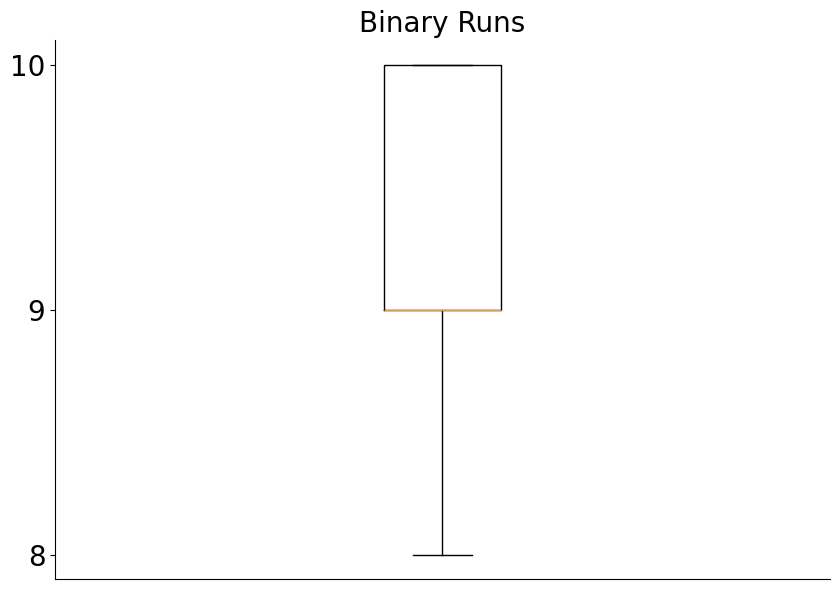

In [11]:
plt.figure(figsize=(10, 7))
plt.boxplot(binary_runs, medianprops=dict(color="#EF9536"))
plt.title("Binary Runs", fontsize=20)
# set dpi to 300 for better quality

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.yticks(ticks=[8, 9, 10], fontsize=20)

plt.xticks([])
plt.savefig("binary_runs.png", dpi=300)

In [176]:
def plot(
    algorithm,
    metric=None,
    *,
    samples=15000,
    scores=None,
    saved_runs=None,
    save_fig=False,
    transparent=False,
    **kwargs,
):

    plt.figure(figsize=(18, 9))

    saved_runs_means = [np.mean(saved_run) for saved_run in saved_runs]
    scores_means = [np.mean(score) / 100 for score in scores]

    # Find the vertical line where saved runs become negative
    negative_indices = [
        i for i, saved_run in enumerate(saved_runs_means) if saved_run < 0
    ]

    if negative_indices:
        negative_index = negative_indices[
            -1
        ]  # Find the last index where saved runs are negative
        # Perform linear interpolation
        x1 = scores_means[negative_index]
        y1 = saved_runs_means[negative_index]
        x2 = scores_means[negative_index + 1]
        y2 = saved_runs_means[negative_index + 1]

        x_zero_cross = x1 + (0 - y1) / (y2 - y1) * (x2 - x1)

        plt.axvline(
            x=x_zero_cross,
            color="#EC6602",
            linestyle="--",
            linewidth=1.5,
            label="_nolegend_",
        )
        plt.axhline(
            y=0,
            color="#EC6602",
            linestyle="--",
            linewidth=1.5,
            label="_nolegend_",
        )
        x_zero_cross = f"{x_zero_cross:.4f}"
        # x_zero_cross = f'{x_zero_cross/100:.2f}'
        # plt.axhline(y=0, color="#EC6602", linestyle="--", linewidth=1.5)

    else:
        x_zero_cross = None
    # Plot with labels for the legend
    plt.boxplot(
        saved_runs,
        positions=scores_means,
        widths=0.0005,
        medianprops=dict(color="#EF9536"),
    )

    plt.plot(
        scores_means,
        saved_runs_means,
        marker="o",
        linestyle="--",
        color="#4EAD90",
        label="_nolegend_",
        linewidth=3,
        **kwargs,
    )

    plt.legend(
        [f"Samples: {samples}\nThreshold: {x_zero_cross}"],
        loc="upper right",
        fontsize=10,
        frameon=False,
        shadow=False,
        title="Info",
        title_fontsize="20",
    )
    # plt.title('Saved Runs Vs Model Scores using Hit Or Miss Algorithm', fontsize=20)
    if metric == "Weighted Binary Crossentropy Loss":
        plt.xlabel(f"Loss Values ({metric})", fontsize=25)
    else:
        plt.xlabel(f"Score Values ({metric})", fontsize=25)
    plt.ylabel("Saved Runs", fontsize=25)

    ax = plt.gca()
    # ax.minorticks_on()
    plt.grid(which="both", axis="both", linestyle="-", linewidth="0.3", color="gray")

    # max = int(np.max(scores_means))
    max = round(np.max(scores_means), 2)

    plt.xticks(
        ticks=np.arange(0, max, 0.001), labels=np.arange(0, max, 0.001), fontsize=20
    )
    plt.yticks(fontsize=20)

    plt.xlim(0, 0.008)
    plt.ylim(int(np.min(saved_runs)) - 10, int(np.max(saved_runs)) + 500)

    # ax.yaxis.set_major_locator(MaxNLocator(nbins=15))
    # ax.xaxis.set_major_locator(MaxNLocator(nbins=45))

    # For positive only
    # plt.ylim(-10, 80)
    # plt.xlim(0, 0.01)

    # plt.xticks(ticks = np.arange(0, 0.015, 0.001), labels=np.arange(0, 0.015, 0.001), fontsize=20)
    # plt.yticks(fontsize=20)

    ax.yaxis.set_major_locator(MaxNLocator(nbins=13))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=9))

    # Remove borders
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    if save_fig:
        if transparent:
            transparency = "transparent"
        else:
            transparency = "non-transparent"

        directory = "Graphs/"

        if not os.path.exists(directory):
            os.makedirs(directory)

        plt.savefig(
            os.path.join(directory, f"{algorithm}_{transparency}_{metric}.png"),
            transparent=transparent,
            dpi=350,
        )

    plt.show

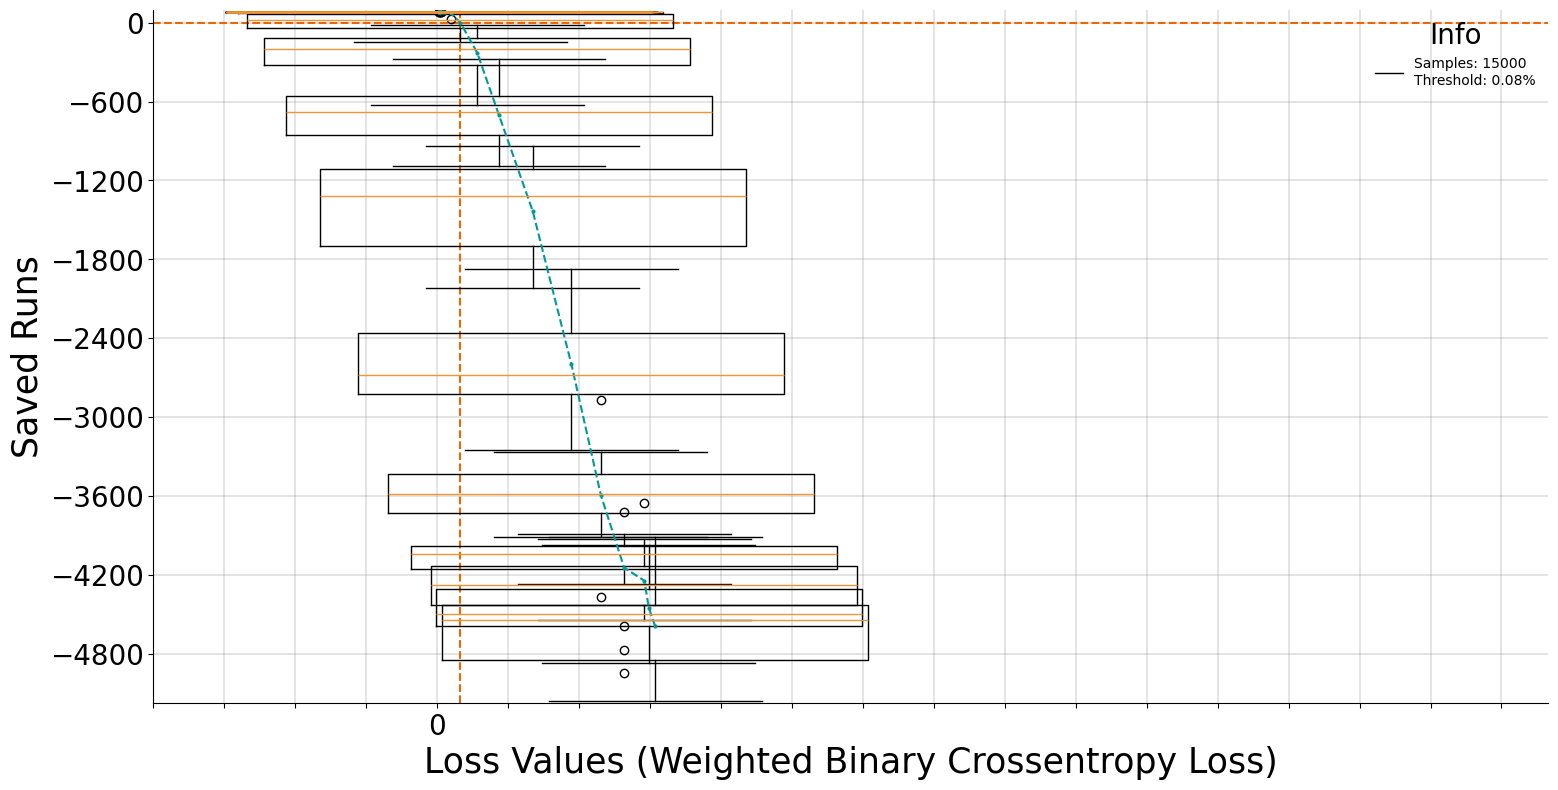

In [11]:
plot(
    algorithm="Hit Or Miss",
    # metric='Weighted Binary Crossentropy Loss',
    metric="Weighted Binary Crossentropy Loss",
    samples=15000,
    scores=scores,
    saved_runs=saved_runs,
    save_fig=True,
    transparent=False,
    markersize=2,
)

## 3D ploting 

In [ ]:
saved_runs_plot = []
scores_plot = []
alphas_plot = []
binary_runs_plot = []

for alpha in np.arange(0.0, 1.1, 0.1):
    saved_runs, scores, binary_runs = main(
        n_iterations=14,
        stats=False,
        metric="weighted_binary_cross_entropy",
        algorithm="hybrid_search",
        save_results=True,
        max_depth=29,
        alpha=alpha,
    )
    print(f"alpha: {alpha}")
    binary_runs_plot.append(binary_runs)
    saved_runs_plot.append(saved_runs)
    scores_plot.append(scores)
    alphas_plot.append(alpha)

In [ ]:
print(f"alpha plot length: {len(alphas_plot)}")
print(f"saved_runs plot length: {len(saved_runs_plot)}")
print(f"scores plot length: {len(scores_plot)}")

In [ ]:
# prepare for three dimensional plot
len(saved_runs_plot)
num_of_alphas = len(alphas_plot)
# max_max_depth
max_max_depth = 29
scores_results_graph = []
saved_runs_graph = []
alphas_graph = []
for saved_run_iter in scores_plot:
    for val in saved_run_iter:
        scores_results_graph.append(np.mean(val))


for saved_run_iter in saved_runs_plot:
    for val in saved_run_iter:
        saved_runs_graph.append(np.mean(val))

# convresion of alpha to be the same length as the saved_runs_graph
# same value of alpha for each 30 iterations
for i in range(num_of_alphas):
    for j in range(max_max_depth - 1):
        alphas_graph.append(alphas_plot[i])

# Assertion to check the length of the saved_runs_graph and scores_results_graph and alphas_graph
assert len(alphas_graph) == len(saved_runs_graph) == len(scores_results_graph)

print(f"length of saved_runs_graph: {len(saved_runs_graph)}")
print(f"length of scores_results_graph: {len(alphas_graph)}")

In [ ]:
# 3D plot -- the 3D surface plot
plot_3d(
    alphas_graph,
    scores_results_graph,
    saved_runs_graph,
    title=None,
    x_label="alpha",
    y_label="wBCE loss",
    z_label="Saved Runs",
    save_fig=True,
    transparent=True,
    width=1000,
    height=1000,
    algorithm="hybrid_search_algo",
    contour=False,
)

In [ ]:
# out contour heatmap plot
plot_3d(
    alphas_graph,
    scores_results_graph,
    saved_runs_graph,
    title=None,
    x_label="alpha",
    y_label="wBCE loss",
    z_label="Saved Runs",
    save_fig=True,
    transparent=True,
    width=1000,
    height=1000,
    algorithm="hybrid_search_algo",
    contour=True,
)  # contour plot